In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Crop-Disease/CropDisease.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [ ]:
# Set up the parameters for the data generators
train_data_dir = '/content/CropDisease/train'
test_data_dir = '/content/CropDisease/test'
batch_size = 32
img_size = (128, 128)

In [ ]:
# Set up the data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle = True
)

Found 44343 images belonging to 39 classes.


In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle = False
)

Found 11105 images belonging to 39 classes.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Bidirectional,LSTM,Lambda, GRU
from tensorflow.keras.layers import Permute,GlobalMaxPool1D,Concatenate, Dense, BatchNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from keras import backend as K

In [ ]:
num_classes = 39

In [ ]:
from keras.layers import Reshape


In [ ]:
from keras.layers import CuDNNGRU

input_ = Input(shape=(128,128,1))
lambda_ = Lambda(lambda x: tf.squeeze(x,axis=3))(input_)

lstm_ = Bidirectional(CuDNNGRU(8, return_sequences=True))(lambda_)

permute_=Permute((2,1),input_shape=(64,64))(lambda_)
lstm_2 = Bidirectional(CuDNNGRU(8, return_sequences=True))(permute_)

lstm_ = BatchNormalization()(lstm_)
maxpool1 = GlobalMaxPool1D()(lstm_)

lstm_2 = BatchNormalization()(lstm_2)
maxpool2 = GlobalMaxPool1D()(lstm_2)

concat_ = Concatenate(axis=1)([maxpool1,maxpool2])
dense_1 = Dense(20,activation='relu')(concat_)
output_ = Dense(39,activation='softmax')(dense_1)

model = Model(input_,output_)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128)     0           ['input_2[0][0]']                
                                                                                                  
 permute_1 (Permute)            (None, 128, 128)     0           ['lambda_1[0][0]']               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 128, 16)     6624        ['lambda_1[0][0]']         

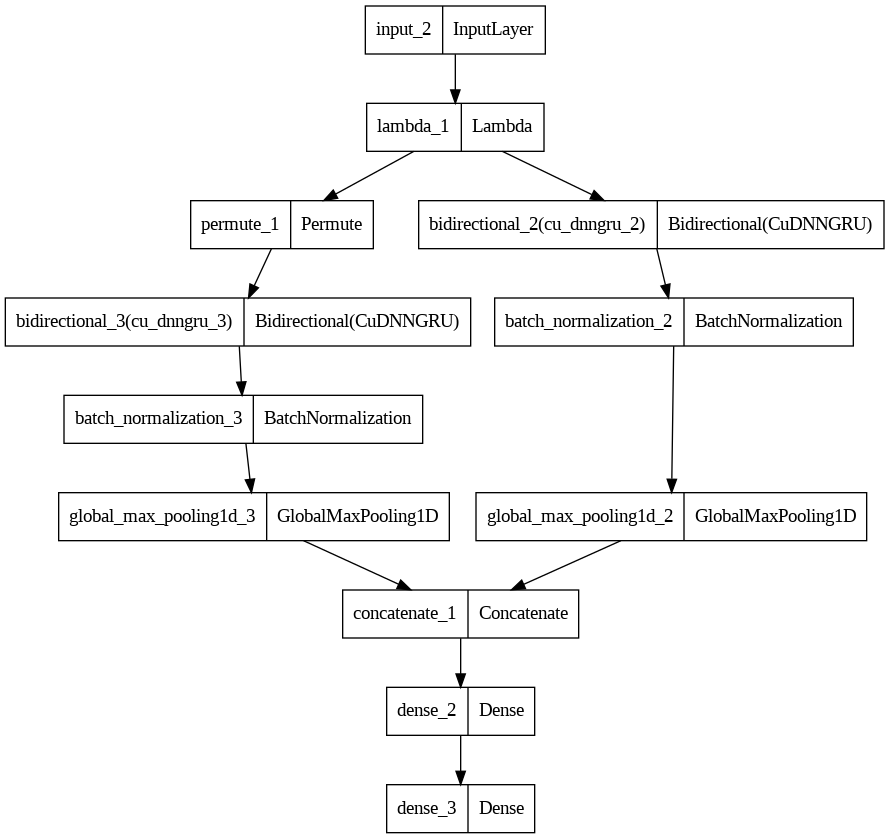

In [ ]:
plot_model(model)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Train the model
epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.n // batch_size
)

Epoch 1/20
1385/1385 [==============================] - 177s 128ms/step - loss: 1.5167 - accuracy: 0.5494 - val_loss: 2.2370 - val_accuracy: 0.4176
Epoch 2/20
1385/1385 [==============================] - 198s 143ms/step - loss: 1.5100 - accuracy: 0.5536 - val_loss: 2.4588 - val_accuracy: 0.3824
Epoch 3/20
1385/1385 [==============================] - 198s 143ms/step - loss: 1.5008 - accuracy: 0.5569 - val_loss: 1.7408 - val_accuracy: 0.5036
Epoch 4/20
1385/1385 [==============================] - 176s 127ms/step - loss: 1.4918 - accuracy: 0.5569 - val_loss: 2.1036 - val_accuracy: 0.4307
Epoch 5/20
1385/1385 [==============================] - 175s 127ms/step - loss: 1.4940 - accuracy: 0.5583 - val_loss: 1.6099 - val_accuracy: 0.5261
Epoch 6/20
1385/1385 [==============================] - 174s 125ms/step - loss: 1.4894 - accuracy: 0.5592 - val_loss: 1.6205 - val_accuracy: 0.5300
Epoch 7/20
1385/1385 [==============================] - 172s 124ms/step - loss: 1.4779 - accuracy: 0.5643 - val_

In [ ]:
model.save('GRUSecond.h5')

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
# Generate predictions for the test set
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

# Generate a classification report with output_dict=True
report = classification_report(y_true, y_pred, output_dict=True)

348/348 [==============================] - 21s 60ms/step


In [ ]:
# create a dataframe from the classification report
df = pd.DataFrame(report).transpose()

In [ ]:
df.tail(12)

,precision,recall,f1-score,support
30,0.857143,0.030000,0.057971,200.000000
31,0.400000,0.089005,0.145610,382.000000
32,0.125000,0.005236,0.010050,191.000000
33,0.228261,0.059155,0.093960,355.000000
34,0.364090,0.434524,0.396201,336.000000
35,0.261538,0.181495,0.214286,281.000000
36,0.864821,0.495336,0.629893,1072.000000
37,0.476190,0.133333,0.208333,75.000000
38,0.299691,0.912226,0.451163,319.000000
accuracy,0.476992,0.476992,0.476992,0.476992


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.style.use('dark_background')

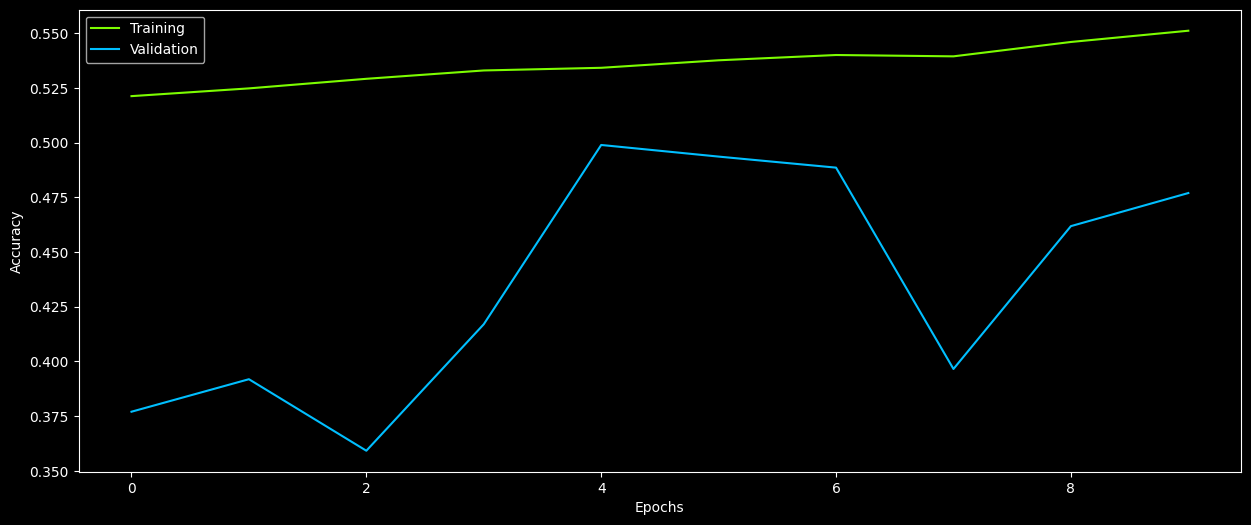

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(15,6))
plt.plot(epochs,acc,c="lawngreen",label="Training")
plt.plot(epochs,val_acc,c="deepskyblue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

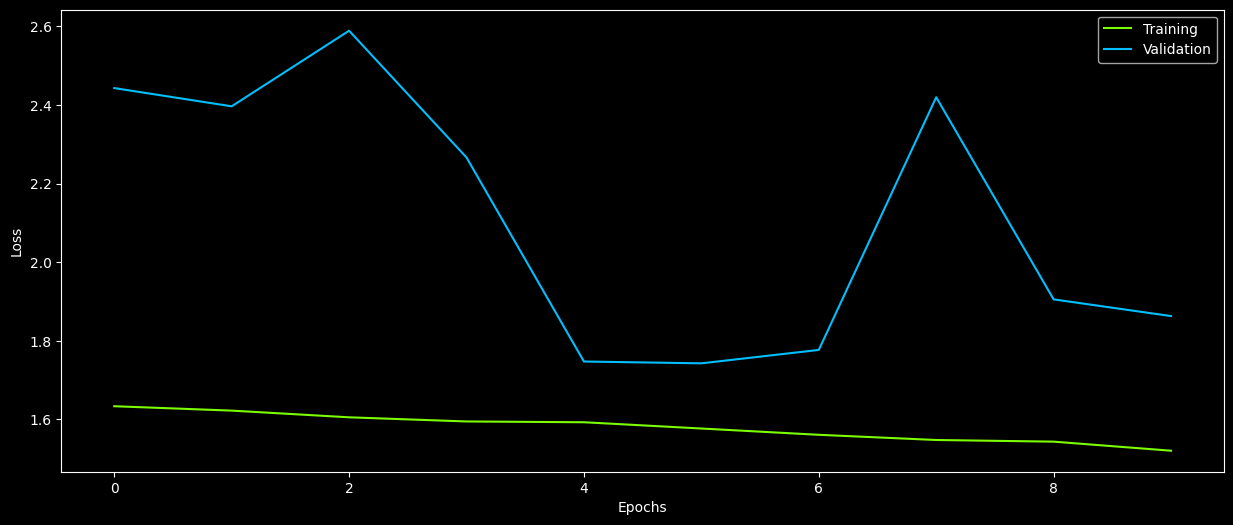

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(15,6))
plt.plot(epochs,loss,c="lawngreen",label="Training")
plt.plot(epochs,val_loss,c="deepskyblue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()